In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pickle
import seaborn as sns
from sklearn import metrics
from sklearn.datasets import make_classification
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, precision_recall_fscore_support
from sklearn.model_selection import GridSearchCV, StratifiedKFold
from sklearn.preprocessing import KBinsDiscretizer as kbd, MinMaxScaler
import warnings
warnings.filterwarnings('ignore')

In [ ]:
df_nba = pd.read_csv('df_1980_2020.csv', sep = ',', decimal = '.')

In [ ]:
df_nba.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 19111 entries, 0 to 19110
Data columns (total 31 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Player             19111 non-null  object 
 1   Pos                19111 non-null  object 
 2   Age                19111 non-null  int64  
 3   Team               19111 non-null  object 
 4   G                  19111 non-null  int64  
 5   GS                 19111 non-null  int64  
 6   MP                 19111 non-null  float64
 7   FG%                19111 non-null  float64
 8   3P%                19111 non-null  float64
 9   2P%                19111 non-null  float64
 10  eFG%               19111 non-null  float64
 11  FT%                19111 non-null  float64
 12  TRB                19111 non-null  float64
 13  AST                19111 non-null  float64
 14  STL                19111 non-null  float64
 15  BLK                19111 non-null  float64
 16  TOV                191

In [ ]:
# Dividir dataset em treino/teste (até 2019) e predição (2020)
df_nba_1980_2019 = df_nba[df_nba.Season <= 2019]
df_nba_2020 = df_nba[df_nba.Season == 2020]

In [ ]:
df_nba_1980_2019.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 18520 entries, 0 to 18519
Data columns (total 31 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Player             18520 non-null  object 
 1   Pos                18520 non-null  object 
 2   Age                18520 non-null  int64  
 3   Team               18520 non-null  object 
 4   G                  18520 non-null  int64  
 5   GS                 18520 non-null  int64  
 6   MP                 18520 non-null  float64
 7   FG%                18520 non-null  float64
 8   3P%                18520 non-null  float64
 9   2P%                18520 non-null  float64
 10  eFG%               18520 non-null  float64
 11  FT%                18520 non-null  float64
 12  TRB                18520 non-null  float64
 13  AST                18520 non-null  float64
 14  STL                18520 non-null  float64
 15  BLK                18520 non-null  float64
 16  TOV                185

In [ ]:
# Verificar correlações de todas as variáveis com a variável 'Share'
corr = df_nba_1980_2019.corr(method = 'pearson')
share_corr = corr[['Share']]
share_corr.Share.abs().sort_values()

Season               0.013671
Age                  0.016094
3P%                  0.029553
FT%                  0.046246
eFG%                 0.059184
2P%                  0.062244
FG%                  0.064319
PF                   0.069308
TS%                  0.075760
G                    0.100509
BPM                  0.102432
Team Overall Seed    0.126694
BLK                  0.152135
WS/48                0.153003
MP                   0.166113
GS                   0.175122
STL                  0.180469
USG%                 0.183948
TRB                  0.188963
AST                  0.195554
PER                  0.206396
TOV                  0.223544
PTS                  0.283826
WS                   0.384053
VORP                 0.470094
First                0.819418
Pts Won              0.982305
Share                1.000000
Name: Share, dtype: float64

In [ ]:
# Conforme resultado acima, não há correlações boas com a variável 'Share'

# Filtrando por jogadores que receberam pontos na votação do prêmio
len(df_nba_1980_2019[(df_nba_1980_2019['Pts Won'] > 0)]['Pts Won'])

653

In [ ]:
# Conforme resultado acima, de 18.520 registros, apenas 653 receberam pontos na premiação, ou seja, 3,5% dos jogadores

# Filtrando dataset para atender a regra acima
df_nba_1980_2019_filtered = df_nba_1980_2019[df_nba_1980_2019['Pts Won'] > 0]
df_nba_1980_2019_filtered.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 653 entries, 0 to 18491
Data columns (total 31 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Player             653 non-null    object 
 1   Pos                653 non-null    object 
 2   Age                653 non-null    int64  
 3   Team               653 non-null    object 
 4   G                  653 non-null    int64  
 5   GS                 653 non-null    int64  
 6   MP                 653 non-null    float64
 7   FG%                653 non-null    float64
 8   3P%                653 non-null    float64
 9   2P%                653 non-null    float64
 10  eFG%               653 non-null    float64
 11  FT%                653 non-null    float64
 12  TRB                653 non-null    float64
 13  AST                653 non-null    float64
 14  STL                653 non-null    float64
 15  BLK                653 non-null    float64
 16  TOV                653 n

In [ ]:
df_nba_1980_2019_filtered['MVP Rank'] = df_nba_1980_2019_filtered.groupby('Season')['Pts Won'].rank(ascending = False, method = 'dense')
df_nba_1980_2019_filtered['Won MVP'] = np.where(df_nba_1980_2019_filtered['MVP Rank'] == 1, 1, 0)

In [ ]:
# Verificar correlações de todas as variáveis com a variável 'Share'
corr = df_nba_1980_2019_filtered.corr(method = 'pearson')
share_corr = corr[['Won MVP']]
share_corr['Won MVP'].abs().sort_values()

Age                  0.037204
Season               0.038146
3P%                  0.042690
BLK                  0.049510
GS                   0.055468
STL                  0.070101
FG%                  0.072102
G                    0.084857
TRB                  0.087952
FT%                  0.101010
2P%                  0.103900
AST                  0.108268
PF                   0.112597
MP                   0.112925
eFG%                 0.116773
TOV                  0.137537
TS%                  0.157274
USG%                 0.190900
PTS                  0.237637
Team Overall Seed    0.238365
PER                  0.347430
BPM                  0.371729
WS/48                0.385531
VORP                 0.390399
WS                   0.399758
MVP Rank             0.409464
Pts Won              0.687994
Share                0.719011
First                0.890753
Won MVP              1.000000
Name: Won MVP, dtype: float64

In [ ]:
df_nba_1980_2019_filtered.tail(15)

,Player,Pos,Age,Team,G,GS,MP,FG%,3P%,2P%,eFG%,FT%,TRB,AST,STL,BLK,TOV,PF,PTS,Season,PER,TS%,USG%,WS,WS/48,BPM,VORP,First,Pts Won,Share,Team Overall Seed,MVP Rank,Won MVP
17628,Damian Lillard,PG,27,POR,73,73,36.6,0.439,0.361,0.501,0.519,0.916,4.5,6.6,1.1,0.4,2.8,1.6,26.9,2018,25.2,0.594,30.6,12.6,0.227,7.2,6.3,0,207,0.205,7,4.0,0
17722,Victor Oladipo,SG,25,IND,75,75,34.0,0.477,0.371,0.528,0.537,0.799,5.2,4.3,2.4,0.8,2.9,2.3,23.1,2018,23.1,0.577,30.1,8.2,0.155,5.8,5.0,0,2,0.002,8,12.0,0
17862,Russell Westbrook,PG,29,OKC,80,80,36.4,0.449,0.298,0.485,0.477,0.737,10.1,10.3,1.8,0.3,4.8,2.5,25.4,2018,24.7,0.524,34.1,10.1,0.166,6.3,6.1,0,76,0.075,10,5.0,0
17916,Giannis Antetokounmpo,PF,24,MIL,72,72,32.8,0.578,0.256,0.641,0.599,0.729,12.5,5.9,1.3,1.5,3.7,3.2,27.7,2019,30.9,0.644,32.3,14.4,0.292,10.4,7.4,78,941,0.932,1,1.0,1
18040,Stephen Curry,PG,30,GSW,69,69,33.8,0.472,0.437,0.525,0.604,0.916,5.3,5.2,1.3,0.4,2.8,2.4,27.3,2019,24.4,0.641,30.4,9.7,0.199,6.6,5.1,0,175,0.173,3,5.0,0
18069,Kevin Durant,SF,30,GSW,78,78,34.6,0.521,0.353,0.587,0.571,0.885,6.4,5.9,0.7,1.1,2.9,2.0,26.0,2019,24.2,0.631,29.0,11.5,0.204,5.5,5.1,0,25,0.025,3,8.0,0
18076,Joel Embiid,C,24,PHI,64,64,33.7,0.484,0.300,0.535,0.517,0.804,13.6,3.7,0.7,1.9,3.5,3.3,27.5,2019,26.1,0.593,33.3,8.7,0.194,4.9,3.8,0,49,0.049,7,7.0,0
18110,Paul George,SF,28,OKC,77,77,36.9,0.438,0.386,0.484,0.529,0.839,8.2,4.1,2.2,0.4,2.7,2.8,28.0,2019,23.3,0.583,29.5,11.9,0.201,7.2,6.6,0,356,0.352,10,3.0,0
18114,Rudy Gobert,C,26,UTA,81,80,31.8,0.669,0.000,0.669,0.669,0.636,12.9,2.0,0.8,2.3,1.6,2.9,15.9,2019,24.6,0.682,17.8,14.4,0.268,5.4,4.8,0,1,0.001,8,11.0,0
18135,James Harden,PG,29,HOU,78,78,36.8,0.442,0.368,0.528,0.541,0.879,6.6,7.5,2.0,0.7,5.0,3.1,36.1,2019,30.6,0.616,40.5,15.2,0.254,11.0,9.3,23,776,0.768,5,2.0,0


In [ ]:
# Método para gerar gráficos
def plot_two_variables(title, var1, var1_order, var2, var2_order):
    plt.style.use('fivethirtyeight')
    fig, ax = plt.subplots()

    mvp = df_nba_1980_2019_filtered[df_nba_1980_2019_filtered['Won MVP'] == 1]
    non_mvp = df_nba_1980_2019_filtered[df_nba_1980_2019_filtered['Won MVP'] != 1]

    ax.scatter(mvp[var1], mvp[var2], label = 'MVP', marker = '^', s = 100)
    ax.scatter(non_mvp[var1], non_mvp[var2], label = 'Não MVP', alpha = .2)

    ax.legend(loc = 'best', prop = {'size': 9, 'family': 'Rockwell'})

    ax.set_xlabel(var1)
    ax.set_ylabel(var2)

    ax.set_xlim(ax.get_xlim()[::var1_order])
    ax.set_ylim(ax.get_ylim()[::var2_order])
  
    fig.suptitle(title, weight = 'bold', size = 18)

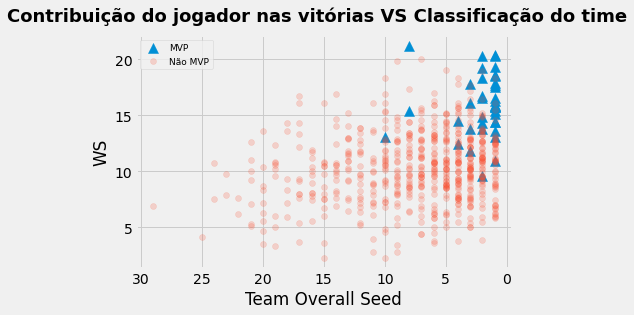

In [ ]:
plot_two_variables('Contribuição do jogador nas vitórias VS Classificação do time', 'Team Overall Seed', -1, 'WS', 1)

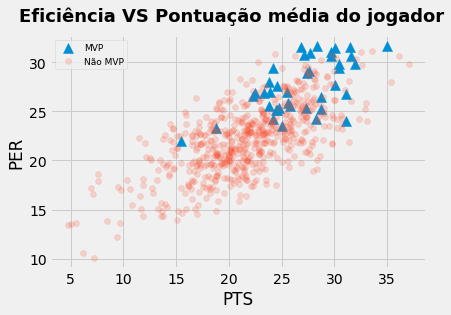

In [ ]:
plot_two_variables('Eficiência VS Pontuação média do jogador', 'PTS', 1, 'PER', 1)

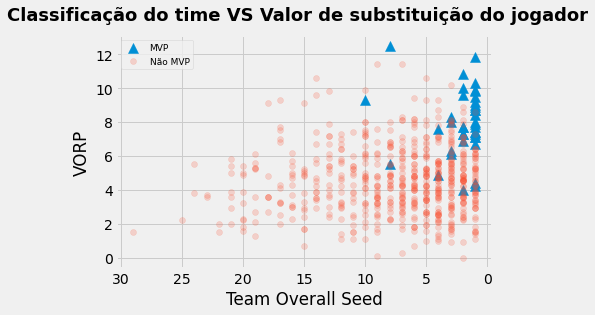

In [ ]:
plot_two_variables('Classificação do time VS Valor de substituição do jogador', 'Team Overall Seed', -1, 'VORP', 1)

In [ ]:
# Construir modelos
def build_models(alg):
    if alg == 'logistic_regression':
        model = LogisticRegression(solver = 'liblinear')
        return model
    else:
        raise Exception('Modelo não implementado')

In [ ]:
# Construir features
def build_features(df_train, df_test):
    mms = MinMaxScaler()
    x_train_mms = mms.fit_transform(df_train[['VORP', 'WS', 'WS/48', 'BPM', 'PER', 'PTS', 'USG%', 'Team Overall Seed', 'TS%', 'eFG%', 'TOV', '2P%', 'MP', 'STL', 'GS', 'AST', 'FG%', 'PF', 'TRB', 'G', 'FT%' , 'BLK', '3P%', 'Age']])
    x_test_mms = mms.transform(df_test[['VORP', 'WS', 'WS/48', 'BPM', 'PER', 'PTS', 'USG%', 'Team Overall Seed', 'TS%', 'eFG%', 'TOV', '2P%', 'MP', 'STL', 'GS', 'AST', 'FG%', 'PF', 'TRB', 'G', 'FT%' , 'BLK', '3P%', 'Age']])

    x_train = np.hstack([x_train_mms])
    x_test = np.hstack([x_test_mms])

    y_train = df_train['Won MVP'].values.reshape(-1, 1)
    y_test = df_test['Won MVP'].values.reshape(-1, 1)

    return x_train, y_train, x_test, y_test

In [ ]:
# Método para visualizar resultados
def print_result(algs, results_matrix):
    for alg_index, alg in enumerate(algs):
        if (alg_index > 0):
            print('-' * 50)

        print('Algoritmo:', alg)
        print()
        print('Treino')
        print('Acurácia:', results_matrix[alg_index, :, 0, 0].mean())
        print('Precisão:', results_matrix[alg_index, :, 1, 0].mean())
        print('Cobertura:', results_matrix[alg_index, :, 2, 0].mean())
        print('Medida F:', results_matrix[alg_index, :, 3, 0].mean())
        print()
        print('Teste')
        print('Acurácia:', results_matrix[alg_index, :, 0, 1].mean())
        print('Precisão:', results_matrix[alg_index, :, 1, 1].mean())
        print('Cobertura:', results_matrix[alg_index, :, 2, 1].mean())
        print('Medida F:', results_matrix[alg_index, :, 3, 1].mean())

In [ ]:
# Execução segmentada (Treino: todas temporadas exceto a da vez / Teste: somente a temporada da vez)
df_pred = []

k = 2019 - 1980
algs = ['logistic_regression']
results_matrix = np.zeros(shape = (len(algs), k, 4, 2))
for alg_index, alg in enumerate(algs):
    for season in range(1980, 2019):
        fold = season - 1980 - 1
        df_train = df_nba_1980_2019_filtered[df_nba_1980_2019_filtered.Season != season]
        df_test = df_nba_1980_2019_filtered[df_nba_1980_2019_filtered.Season == season]

        x_train, y_train, x_test, y_test = build_features(df_train, df_test)

        model = build_models(alg)
        model.fit(x_train, y_train)

        # Treino
        y_pred_train = model.predict_proba(x_train)[:, 1]
        df_train_rank = df_train.copy()
        df_train_rank['Predicted MVP'] = y_pred_train

        df_train_rank['Predicted MVP Rank'] = df_train_rank.groupby('Season')['Predicted MVP'].rank(ascending = False, method = 'dense')

        df_train_rank['Predicted MVP Winner'] = df_train_rank['Predicted MVP Rank']
        df_train_rank['Predicted MVP Winner'].loc[df_train_rank['Predicted MVP Winner'] != 1] = 0

        df_train_rank_won_mvp = df_train_rank['Won MVP']
        df_train_rank_predicted_mvp_winner = df_train_rank['Predicted MVP Winner']

        results_matrix[alg_index, fold, 0, 0] = metrics.accuracy_score(df_train_rank_won_mvp, df_train_rank_predicted_mvp_winner)
        results_matrix[alg_index, fold, 1, 0] = metrics.precision_score(df_train_rank_won_mvp, df_train_rank_predicted_mvp_winner)
        results_matrix[alg_index, fold, 2, 0] = metrics.recall_score(df_train_rank_won_mvp, df_train_rank_predicted_mvp_winner)
        results_matrix[alg_index, fold, 3, 0] = metrics.f1_score(df_train_rank_won_mvp, df_train_rank_predicted_mvp_winner)

        # Teste
        y_pred_test = model.predict_proba(x_test)[:, 1]
        df_test_rank = df_test.copy()
        df_test_rank['Predicted MVP'] = y_pred_test

        df_pred.append(df_test_rank)

        df_test_rank['Predicted MVP Rank'] = df_test_rank.groupby('Season')['Predicted MVP'].rank(ascending = False, method = 'dense')

        df_test_rank['Predicted MVP Winner'] = df_test_rank['Predicted MVP Rank']
        df_test_rank['Predicted MVP Winner'].loc[df_test_rank['Predicted MVP Winner'] != 1] = 0

        df_test_rank_won_mvp = df_test_rank['Won MVP']
        df_test_rank_predicted_mvp_winner = df_test_rank['Predicted MVP Winner']

        results_matrix[alg_index, fold, 0, 1] = metrics.accuracy_score(df_test_rank_won_mvp, df_test_rank_predicted_mvp_winner)
        results_matrix[alg_index, fold, 1, 1] = metrics.precision_score(df_test_rank_won_mvp, df_test_rank_predicted_mvp_winner)
        results_matrix[alg_index, fold, 2, 1] = metrics.recall_score(df_test_rank_won_mvp, df_test_rank_predicted_mvp_winner)
        results_matrix[alg_index, fold, 3, 1] = metrics.f1_score(df_test_rank_won_mvp, df_test_rank_predicted_mvp_winner)

In [ ]:
# Resultado da execução segmentada
print_result(algs, results_matrix)

Algoritmo: logistic_regression

Treino
Acurácia: 0.9703523919021649
Precisão: 0.7580539119000659
Cobertura: 0.7580539119000659
Medida F: 0.758053911900066

Teste
Acurácia: 0.9630966597637235
Precisão: 0.717948717948718
Cobertura: 0.717948717948718
Medida F: 0.717948717948718


In [ ]:
df_pred = pd.concat(df_pred)
df_pred = df_pred[['Player', 'Season', 'Won MVP', 'Predicted MVP']]

df_pred['Predicted MVP Rank'] = df_pred.groupby('Season')['Predicted MVP'].rank(ascending = False, method = 'dense')

df_pred['Predicted MVP Winner'] = df_pred['Predicted MVP Rank']
df_pred['Predicted MVP Winner'].loc[df_pred['Predicted MVP Winner'] != 1] = 0

In [ ]:
# Jogadores que ganharam o prêmio e o modelo preveu errado
df_pred[(df_pred['Won MVP'] == 1) & (df_pred['Predicted MVP Winner'] != 1)][['Player', 'Season', 'Predicted MVP Rank']]

,Player,Season,Predicted MVP Rank
862,Moses Malone,1982,3.0
3282,Magic Johnson,1989,2.0
4803,Charles Barkley,1993,2.0
5501,Hakeem Olajuwon,1994,3.0
6828,Karl Malone,1997,2.0
8710,Allen Iverson,2001,2.0
10781,Steve Nash,2005,8.0
11294,Steve Nash,2006,8.0
12040,Kobe Bryant,2008,6.0
13945,Derrick Rose,2011,2.0


In [ ]:
# Jogadores que não ganharam o prêmio e o modelo preveu errado
df_pred[(df_pred['Won MVP'] != 1) & (df_pred['Predicted MVP Winner'] == 1)][['Player', 'Season']]

,Player,Season
673,Larry Bird,1982
3296,Michael Jordan,1989
4964,Michael Jordan,1993
5542,David Robinson,1994
6786,Michael Jordan,1997
8837,Shaquille O'Neal,2001
10580,Tim Duncan,2005
11301,Dirk Nowitzki,2006
12339,Chris Paul,2008
13790,LeBron James,2011


In [ ]:
# Visualizar resultado da classificação
predicted = df_pred['Predicted MVP Winner']
ground_truth = df_pred['Won MVP']

print(classification_report(ground_truth, predicted))

              precision    recall  f1-score   support

           0       0.98      0.98      0.98       602
           1       0.72      0.72      0.72        39

    accuracy                           0.97       641
   macro avg       0.85      0.85      0.85       641
weighted avg       0.97      0.97      0.97       641



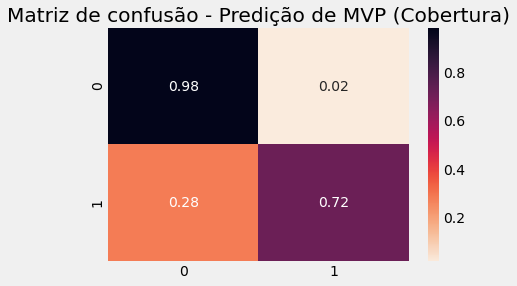

In [ ]:
# Normalizar matriz de confusão para visualizar o resultado da cobertura
cm = confusion_matrix(ground_truth, predicted)
cm = np.transpose(cm.T / cm.astype(np.float).sum(axis = 1))

plt.title('Matriz de confusão - Predição de MVP (Cobertura)')
sns.heatmap(cm, annot = True, fmt = '.2f', cmap = 'rocket_r')
plt.show()

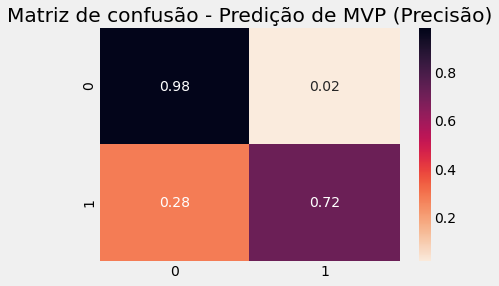

In [ ]:
# Normalizar matriz de confusão para visualizar o resultado da precisão
cm = confusion_matrix(ground_truth, predicted)
cm = np.transpose(cm.T / cm.astype(np.float).sum(axis = 0))

plt.title('Matriz de confusão - Predição de MVP (Precisão)')
sns.heatmap(cm, annot = True, fmt = '.2f', cmap = 'rocket_r')
plt.show()

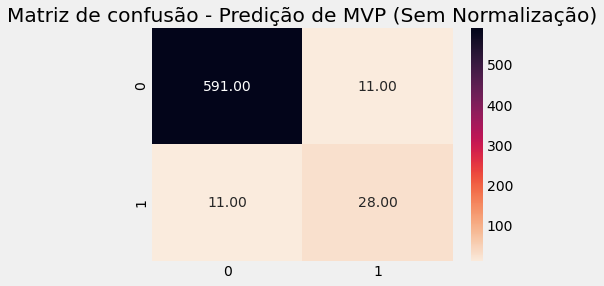

In [ ]:
# Visualizar matriz de confusão sem normalização
cm = confusion_matrix(ground_truth, predicted)

plt.title('Matriz de confusão - Predição de MVP (Sem Normalização)')
sns.heatmap(cm, annot = True, fmt = '.2f', cmap = 'rocket_r')
plt.show()

In [ ]:
# Descobrir melhor parametrização
x_train, y_train, x_test, y_test = build_features(df_nba_1980_2019_filtered, df_nba_1980_2019_filtered)
model = build_models('logistic_regression')
model.fit(x_train, y_train)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='liblinear', tol=0.0001, verbose=0,
                   warm_start=False)

In [ ]:
# Visualizar threshold
for threshold in [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]:
    y_pred_prob = model.predict_proba(x_test)[:, 1]
    y_pred_prob = (y_pred_prob > threshold).astype(int)
    p, r, _, _ = precision_recall_fscore_support(y_test, y_pred_prob, average = 'binary')

    print('Threshold', threshold)
    print('Precisão', p)
    print('Cobertura', r)

Threshold 0.1
Precisão 0.3302752293577982
Cobertura 0.9
Threshold 0.2
Precisão 0.5370370370370371
Cobertura 0.725
Threshold 0.3
Precisão 0.782608695652174
Cobertura 0.45
Threshold 0.4
Precisão 0.8461538461538461
Cobertura 0.275
Threshold 0.5
Precisão 1.0
Cobertura 0.1
Threshold 0.6
Precisão 1.0
Cobertura 0.075
Threshold 0.7
Precisão 1.0
Cobertura 0.025
Threshold 0.8
Precisão 0.0
Cobertura 0.0
Threshold 0.9
Precisão 0.0
Cobertura 0.0


In [ ]:
# Pré-processamento para visualizar Regressão Logística
x, y = make_classification(n_samples = 50, n_features = 1, n_informative = 1, n_redundant = 0, n_clusters_per_class = 1, n_classes = 2)

logistic_regression = LogisticRegression()
logistic_regression.fit(x, y)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

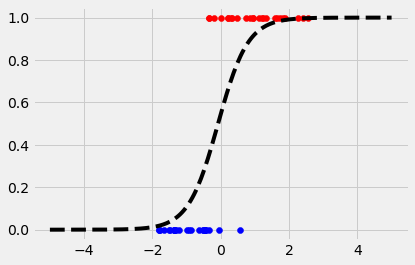

In [ ]:
# Visualizar Regressão Logística (função sigmoid)
plt.scatter(x[y == 0], y[y == 0], c = 'blue')
plt.scatter(x[y == 1], y[y == 1], c = 'red')

new_x = np.linspace(-5, 5, num = 200)
new_y = list()

for n in new_x:
    prob = logistic_regression.predict_proba(n.reshape(-1, 1))
    new_y.append(prob[0, 1])

plt.plot(new_x, new_y, 'k--')
plt.show()

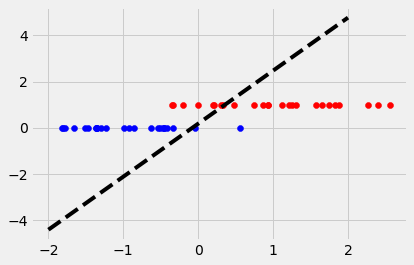

In [ ]:
# Visualizar Regressão Logística (função da reta)
plt.scatter(x[y == 0], y[y == 0], c = 'blue')
plt.scatter(x[y == 1], y[y == 1], c = 'red')

new_x = np.linspace(-2, 2, num = 200)
new_y = list()

for n in new_x:
    _y = logistic_regression.intercept_ + (logistic_regression.coef_[0] * n)
    new_y.append(_y[0])

plt.plot(new_x, new_y, 'k--')
plt.show()

In [ ]:
# Visualizar resultado da classificação
y_pred = logistic_regression.predict(x)
cm = confusion_matrix(y, y_pred)

print(cm)
print(classification_report(y, y_pred))

[[23  2]
 [ 3 22]]
              precision    recall  f1-score   support

           0       0.88      0.92      0.90        25
           1       0.92      0.88      0.90        25

    accuracy                           0.90        50
   macro avg       0.90      0.90      0.90        50
weighted avg       0.90      0.90      0.90        50



In [ ]:
# Prever o MVP de 2020

In [ ]:
# Informações básicas
df_nba_2020.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 591 entries, 18520 to 19110
Data columns (total 31 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Player             591 non-null    object 
 1   Pos                591 non-null    object 
 2   Age                591 non-null    int64  
 3   Team               591 non-null    object 
 4   G                  591 non-null    int64  
 5   GS                 591 non-null    int64  
 6   MP                 591 non-null    float64
 7   FG%                591 non-null    float64
 8   3P%                591 non-null    float64
 9   2P%                591 non-null    float64
 10  eFG%               591 non-null    float64
 11  FT%                591 non-null    float64
 12  TRB                591 non-null    float64
 13  AST                591 non-null    float64
 14  STL                591 non-null    float64
 15  BLK                591 non-null    float64
 16  TOV                5

In [ ]:
df_nba_2020['Won MVP'] = 0
mask2020 = (df_nba_2020.G > 55) & (df_nba_2020.GS > 55)
df_nba_2020 = df_nba_2020[mask2020]

In [ ]:
# Cabeçalho
df_nba_2020.tail(15)

,Player,Pos,Age,Team,G,GS,MP,FG%,3P%,2P%,eFG%,FT%,TRB,AST,STL,BLK,TOV,PF,PTS,Season,PER,TS%,USG%,WS,WS/48,BPM,VORP,First,Pts Won,Share,Team Overall Seed,Won MVP
19027,Tony Snell,SF,28,DET,59,57,27.8,0.445,0.402,0.531,0.579,1.000,1.9,2.2,0.5,0.3,0.5,1.7,8.0,2020,9.7,0.598,11.4,2.6,0.076,-1.8,0.1,0,0,0.000,27,0
19033,Jayson Tatum,PF,21,BOS,66,66,34.3,0.450,0.403,0.480,0.527,0.812,7.0,3.0,1.4,0.9,2.3,2.1,23.4,2020,20.4,0.567,28.6,6.9,0.146,4.0,3.4,0,1,0.001,5,0
19037,Daniel Theis,C,27,BOS,65,64,24.1,0.566,0.333,0.633,0.603,0.763,6.6,1.7,0.6,1.3,0.8,3.4,9.2,2020,17.9,0.631,14.4,6.5,0.201,2.4,1.7,0,0,0.000,5,0
19052,P.J. Tucker,PF,34,HOU,72,72,34.3,0.415,0.358,0.551,0.541,0.813,6.6,1.6,1.1,0.5,1.0,3.2,6.9,2020,8.3,0.559,8.7,4.0,0.078,-1.9,0.1,0,0,0.000,8,0
19055,Myles Turner,C,23,IND,62,62,29.5,0.457,0.344,0.540,0.530,0.751,6.6,1.2,0.7,2.1,1.4,2.7,12.1,2020,14.8,0.566,17.9,4.2,0.111,0.1,1.0,0,0,0.000,7,0
19058,Jonas Valančiūnas,C,27,MEM,70,70,26.4,0.585,0.352,0.617,0.606,0.740,11.3,1.9,0.4,1.1,1.8,2.6,14.9,2020,22.2,0.631,21.5,7.0,0.182,2.4,2.0,0,0,0.000,16,0
19066,Nikola Vučević,C,29,ORL,62,62,32.2,0.477,0.339,0.531,0.525,0.784,10.9,3.6,0.9,0.8,1.4,2.2,19.6,2020,21.9,0.549,25.8,6.4,0.153,4.2,3.1,0,0,0.000,18,0
19071,Kemba Walker,PG,29,BOS,56,56,31.1,0.425,0.381,0.476,0.526,0.864,3.9,4.8,0.9,0.5,2.1,1.6,20.4,2020,20.0,0.575,27.2,5.9,0.162,4.6,2.9,0,0,0.000,5,0
19074,Taurean Prince,SF,25,BRK,64,61,29.0,0.376,0.339,0.429,0.475,0.798,6.0,1.8,0.9,0.4,2.0,2.5,12.1,2020,9.1,0.497,20.4,0.6,0.014,-2.9,-0.4,0,0,0.000,14,0
19078,T.J. Warren,SF,26,IND,67,67,32.9,0.536,0.403,0.575,0.581,0.819,4.2,1.5,1.2,0.5,1.3,2.8,19.8,2020,18.4,0.610,23.3,6.5,0.143,1.1,1.7,0,0,0.000,7,0


In [ ]:
# Modelo produtivo
x_train, y_train, x_test, y_test = build_features(df_nba_1980_2019_filtered, df_nba_2020)
x_complete = x_train
y_complete = y_train

production_model = LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

production_model.fit(x_complete, y_complete)

y_pred_prob = production_model.predict_proba(x_test)
df_nba_2020['Predicted MVP'] = y_pred_prob[:, 1]

In [ ]:
df_nba_2020['Predicted MVP Rank'] = df_nba_2020.groupby('Season')['Predicted MVP'].rank(ascending = False, method = 'dense')

df_nba_2020['Predicted MVP Winner'] = df_nba_2020['Predicted MVP Rank']
df_nba_2020['Predicted MVP Winner'].loc[df_nba_2020['Predicted MVP Winner'] != 1] = 0

In [ ]:
df_nba_2020.sort_values(by =['Predicted MVP Rank'], ascending = True).head(15)

,Player,Pos,Age,Team,G,GS,MP,FG%,3P%,2P%,eFG%,FT%,TRB,AST,STL,BLK,TOV,PF,PTS,Season,PER,TS%,USG%,WS,WS/48,BPM,VORP,First,Pts Won,Share,Team Overall Seed,Won MVP,Predicted MVP,Predicted MVP Rank,Predicted MVP Winner
18532,Giannis Antetokounmpo,PF,25,MIL,63,63,30.4,0.553,0.304,0.631,0.589,0.633,13.6,5.6,1.0,1.0,3.7,3.1,29.5,2020,31.9,0.613,37.5,11.1,0.279,11.5,6.6,85,962,0.952,1,0,0.260945,1.0,1.0
18747,James Harden,SG,30,HOU,68,68,36.5,0.444,0.355,0.556,0.543,0.865,6.6,7.5,1.8,0.9,4.5,3.3,34.3,2020,29.1,0.626,36.3,13.1,0.254,9.6,7.3,0,367,0.363,8,0,0.191840,2.0,0.0
18804,LeBron James,PG,35,LAL,67,67,34.6,0.493,0.348,0.564,0.550,0.693,7.8,10.2,1.2,0.5,3.9,1.8,25.3,2020,25.5,0.577,31.5,9.8,0.204,8.4,6.1,16,753,0.746,3,0,0.138508,3.0,0.0
18662,Anthony Davis,PF,26,LAL,62,62,34.4,0.503,0.330,0.546,0.536,0.846,9.3,3.2,1.5,2.3,2.5,2.5,26.1,2020,27.4,0.610,29.3,11.1,0.250,8.0,5.4,0,82,0.081,3,0,0.093453,4.0,0.0
18853,Kawhi Leonard,SF,28,LAC,57,57,32.4,0.470,0.378,0.506,0.524,0.886,7.1,4.9,1.8,0.6,2.6,2.0,27.1,2020,26.9,0.589,33.0,8.7,0.226,8.9,5.1,0,168,0.166,4,0,0.072060,5.0,0.0
18856,Damian Lillard,PG,29,POR,66,66,37.5,0.463,0.401,0.524,0.563,0.888,4.3,8.0,1.1,0.3,2.9,1.7,30.0,2020,26.9,0.627,30.3,11.6,0.225,7.5,5.9,0,23,0.023,15,0,0.046147,6.0,0.0
18675,Luka Dončić,PG,20,DAL,61,61,33.6,0.463,0.316,0.574,0.531,0.758,9.4,8.8,1.0,0.2,4.3,2.5,28.8,2020,27.6,0.585,36.8,8.8,0.207,8.4,5.4,0,200,0.198,12,0,0.037132,7.0,0.0
18817,Nikola Jokić,C,24,DEN,73,73,32.0,0.528,0.314,0.594,0.565,0.817,9.7,7.0,1.2,0.6,3.1,3.0,19.9,2020,24.9,0.605,26.6,9.8,0.202,7.4,5.5,0,18,0.018,6,0,0.027707,8.0,0.0
18610,Jimmy Butler,SF,30,MIA,58,58,33.8,0.455,0.244,0.495,0.474,0.834,6.7,6.0,1.8,0.6,2.2,1.4,19.9,2020,23.6,0.585,25.1,9.0,0.221,5.4,3.7,0,9,0.009,9,0,0.022194,9.0,0.0
18897,Khris Middleton,SF,28,MIL,62,59,29.9,0.497,0.415,0.546,0.575,0.916,6.2,4.3,0.9,0.1,2.2,2.3,20.9,2020,21.1,0.619,26.4,7.9,0.205,4.1,2.9,0,0,0.000,1,0,0.017461,10.0,0.0
